In [107]:
import datetime
import math
from pathlib import Path

import numpy as np
import rasterio
import torch
import yaml
from claymodel.module import ClayMAEModule
from matplotlib import pyplot as plt
from pyproj import Transformer
from rasterio.plot import show
from torchvision.transforms import v2

from estuary.util import contrast_stretch

In [15]:
# Load model
model = ClayMAEModule.load_from_checkpoint(
    "/Users/kyledorman/data/models/clay/clay-v1.5.ckpt",
    metadata_path="/Users/kyledorman/data/models/clay/metadata.yaml",
    mask_ratio=0.0,
    shuffle=False,
)
_ = model.eval()

In [50]:
# Load sensor metadata
with open("/Users/kyledorman/data/models/clay/metadata.yaml") as f:
    metadata = yaml.safe_load(f)

channel_4_band_order = [
    "blue",
    "green",
    "red",
    "nir",
]
planetscope = metadata["planetscope-sr"]
metadata["planetscope-sr-4"] = {}
metadata["planetscope-sr-4"]["band_order"] = channel_4_band_order
metadata["planetscope-sr-4"]["rgb_indices"] = [3, 2, 1]
metadata["planetscope-sr-4"]["gsd"] = 3
bands = {}
for k, vs in planetscope["bands"].items():
    vs4 = {kk: vv for kk, vv in vs.items() if kk in channel_4_band_order}
    bands[k] = vs4
metadata["planetscope-sr-4"]["bands"] = bands

metadata["planetscope-sr-4"]

{'band_order': ['blue', 'green', 'red', 'nir'],
 'rgb_indices': [3, 2, 1],
 'gsd': 3,
 'bands': {'mean': {'blue': 1715.0,
   'green': 2088.0,
   'red': 2290.0,
   'nir': 3970.0},
  'std': {'blue': 698.0, 'green': 768.0, 'red': 868.0, 'nir': 914.0},
  'wavelength': {'blue': 0.49, 'green': 0.565, 'red': 0.665, 'nir': 0.865}}}

In [18]:
pth = "/Users/kyledorman/data/estuary/dove/results/2019/1/pismo_creek_lagoon/files/20190103_175137_104e_3B_AnalyticMS_SR_clip.tif"

In [31]:
datetime_str = "_".join(Path(pth).stem.split("_")[:2])
date_format = "%Y%m%d_%H%M%S"
dt = datetime.datetime.strptime(datetime_str, date_format)
dt

datetime.datetime(2019, 1, 3, 17, 51, 37)

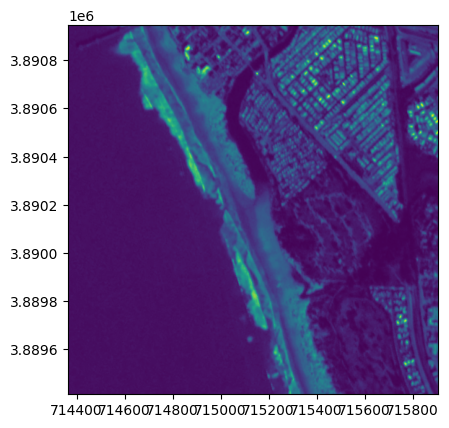

In [79]:
with rasterio.open(pth) as src:
    bounds = src.bounds
    crs = src.crs

    transformer = Transformer.from_crs(crs, 4326)
    # Calculate centroid
    centroid_x = (bounds.left + bounds.right) / 2
    centroid_y = (bounds.top + bounds.bottom) / 2
    centroid_x, centroid_y = transformer.transform(centroid_x, centroid_y)
    bounds_b, bounds_l = transformer.transform(bounds.left, bounds.bottom)
    bounds_t, bounds_r = transformer.transform(bounds.right, bounds.top)

    bounds_g = [bounds_b, bounds_l, bounds_t, bounds_r]
    cent_g = centroid_x, centroid_y

    plt.figure()
    show((src, 1), cmap="viridis")

    data = src.read()
    data = data[:, :512, :512]

In [98]:
def normalize_latlon(lat, lon):
    """
    Normalize latitude and longitude to a range between -1 and 1.

    Parameters:
    lat (float): Latitude value.
    lon (float): Longitude value.

    Returns:
    tuple: Normalized latitude and longitude values.
    """
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


def prep_datacube(image, lat, lon, date):
    """
    Prepare a data cube for model input.

    Parameters:
    image (np.array): The input image array.
    lat (float): Latitude value for the location.
    lon (float): Longitude value for the location.

    Returns:
    dict: Prepared data cube with normalized values and embeddings.
    """
    md = metadata["planetscope-sr-4"]

    # Extract mean, std, and wavelengths from metadata
    mean = []
    std = []
    waves = []
    bands = md["band_order"]
    for band_name in bands:
        mean.append(md["bands"]["mean"][band_name])
        std.append(md["bands"]["std"][band_name])
        waves.append(md["bands"]["wavelength"][band_name] * 1000)

    transform = v2.Compose(
        [
            v2.Resize(size=(256, 256), interpolation=3),
            v2.Normalize(mean=mean, std=std),
        ]
    )

    # Prep datetimes embedding
    times = normalize_timestamp(date)
    week_norm = times[0]
    hour_norm = times[1]

    # Prep lat/lon embedding
    latlons = normalize_latlon(lat, lon)
    lat_norm = latlons[0]
    lon_norm = latlons[1]

    # Prep pixels
    pixels = torch.from_numpy(image.astype(np.float32))
    pixels = transform(pixels)
    pixels = pixels.unsqueeze(0)

    # Prepare additional information
    return {
        "pixels": pixels,
        "time": torch.tensor(
            np.hstack((week_norm, hour_norm)),
            dtype=torch.float32,
        ).unsqueeze(0),
        "latlon": torch.tensor(np.hstack((lat_norm, lon_norm)), dtype=torch.float32).unsqueeze(0),
        "waves": torch.tensor(waves),
        "gsd": torch.tensor(md["gsd"] * 2).unsqueeze(0),
    }

In [102]:
datacube = prep_datacube(data, *cent_g, dt)
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

In [66]:
print(unmsk_patch.shape)
print(unmsk_idx)
print(msk_idx)
print(msk_matrix.shape)

torch.Size([1, 4097, 1024])
tensor([[   0,    1,    2,  ..., 4093, 4094, 4095]])
tensor([], size=(1, 0), dtype=torch.int64)
torch.Size([1, 4096])


In [67]:
# The first embedding is the class token, which is the overall single embedding.
unmsk_patch[:, 0, :].cpu().numpy()

array([[ 0.00199498, -0.0864813 , -0.0521516 , ...,  0.02617873,
         0.05235796,  0.02052316]], dtype=float32)

In [99]:
ep_embedder_cpu = torch.export.load(
    "/Users/kyledorman/data/models/clay/clay-v1.5-encoder_256.pt2"
).module()

In [101]:
%%time
datacube = prep_datacube(data, *cent_g, dt)
with torch.no_grad():
    embeddings = ep_embedder_cpu(datacube)
datacube["pixels"].shape, embeddings.shape

CPU times: user 1.93 s, sys: 381 ms, total: 2.31 s
Wall time: 640 ms


(torch.Size([1, 4, 256, 256]), torch.Size([1, 1024]))

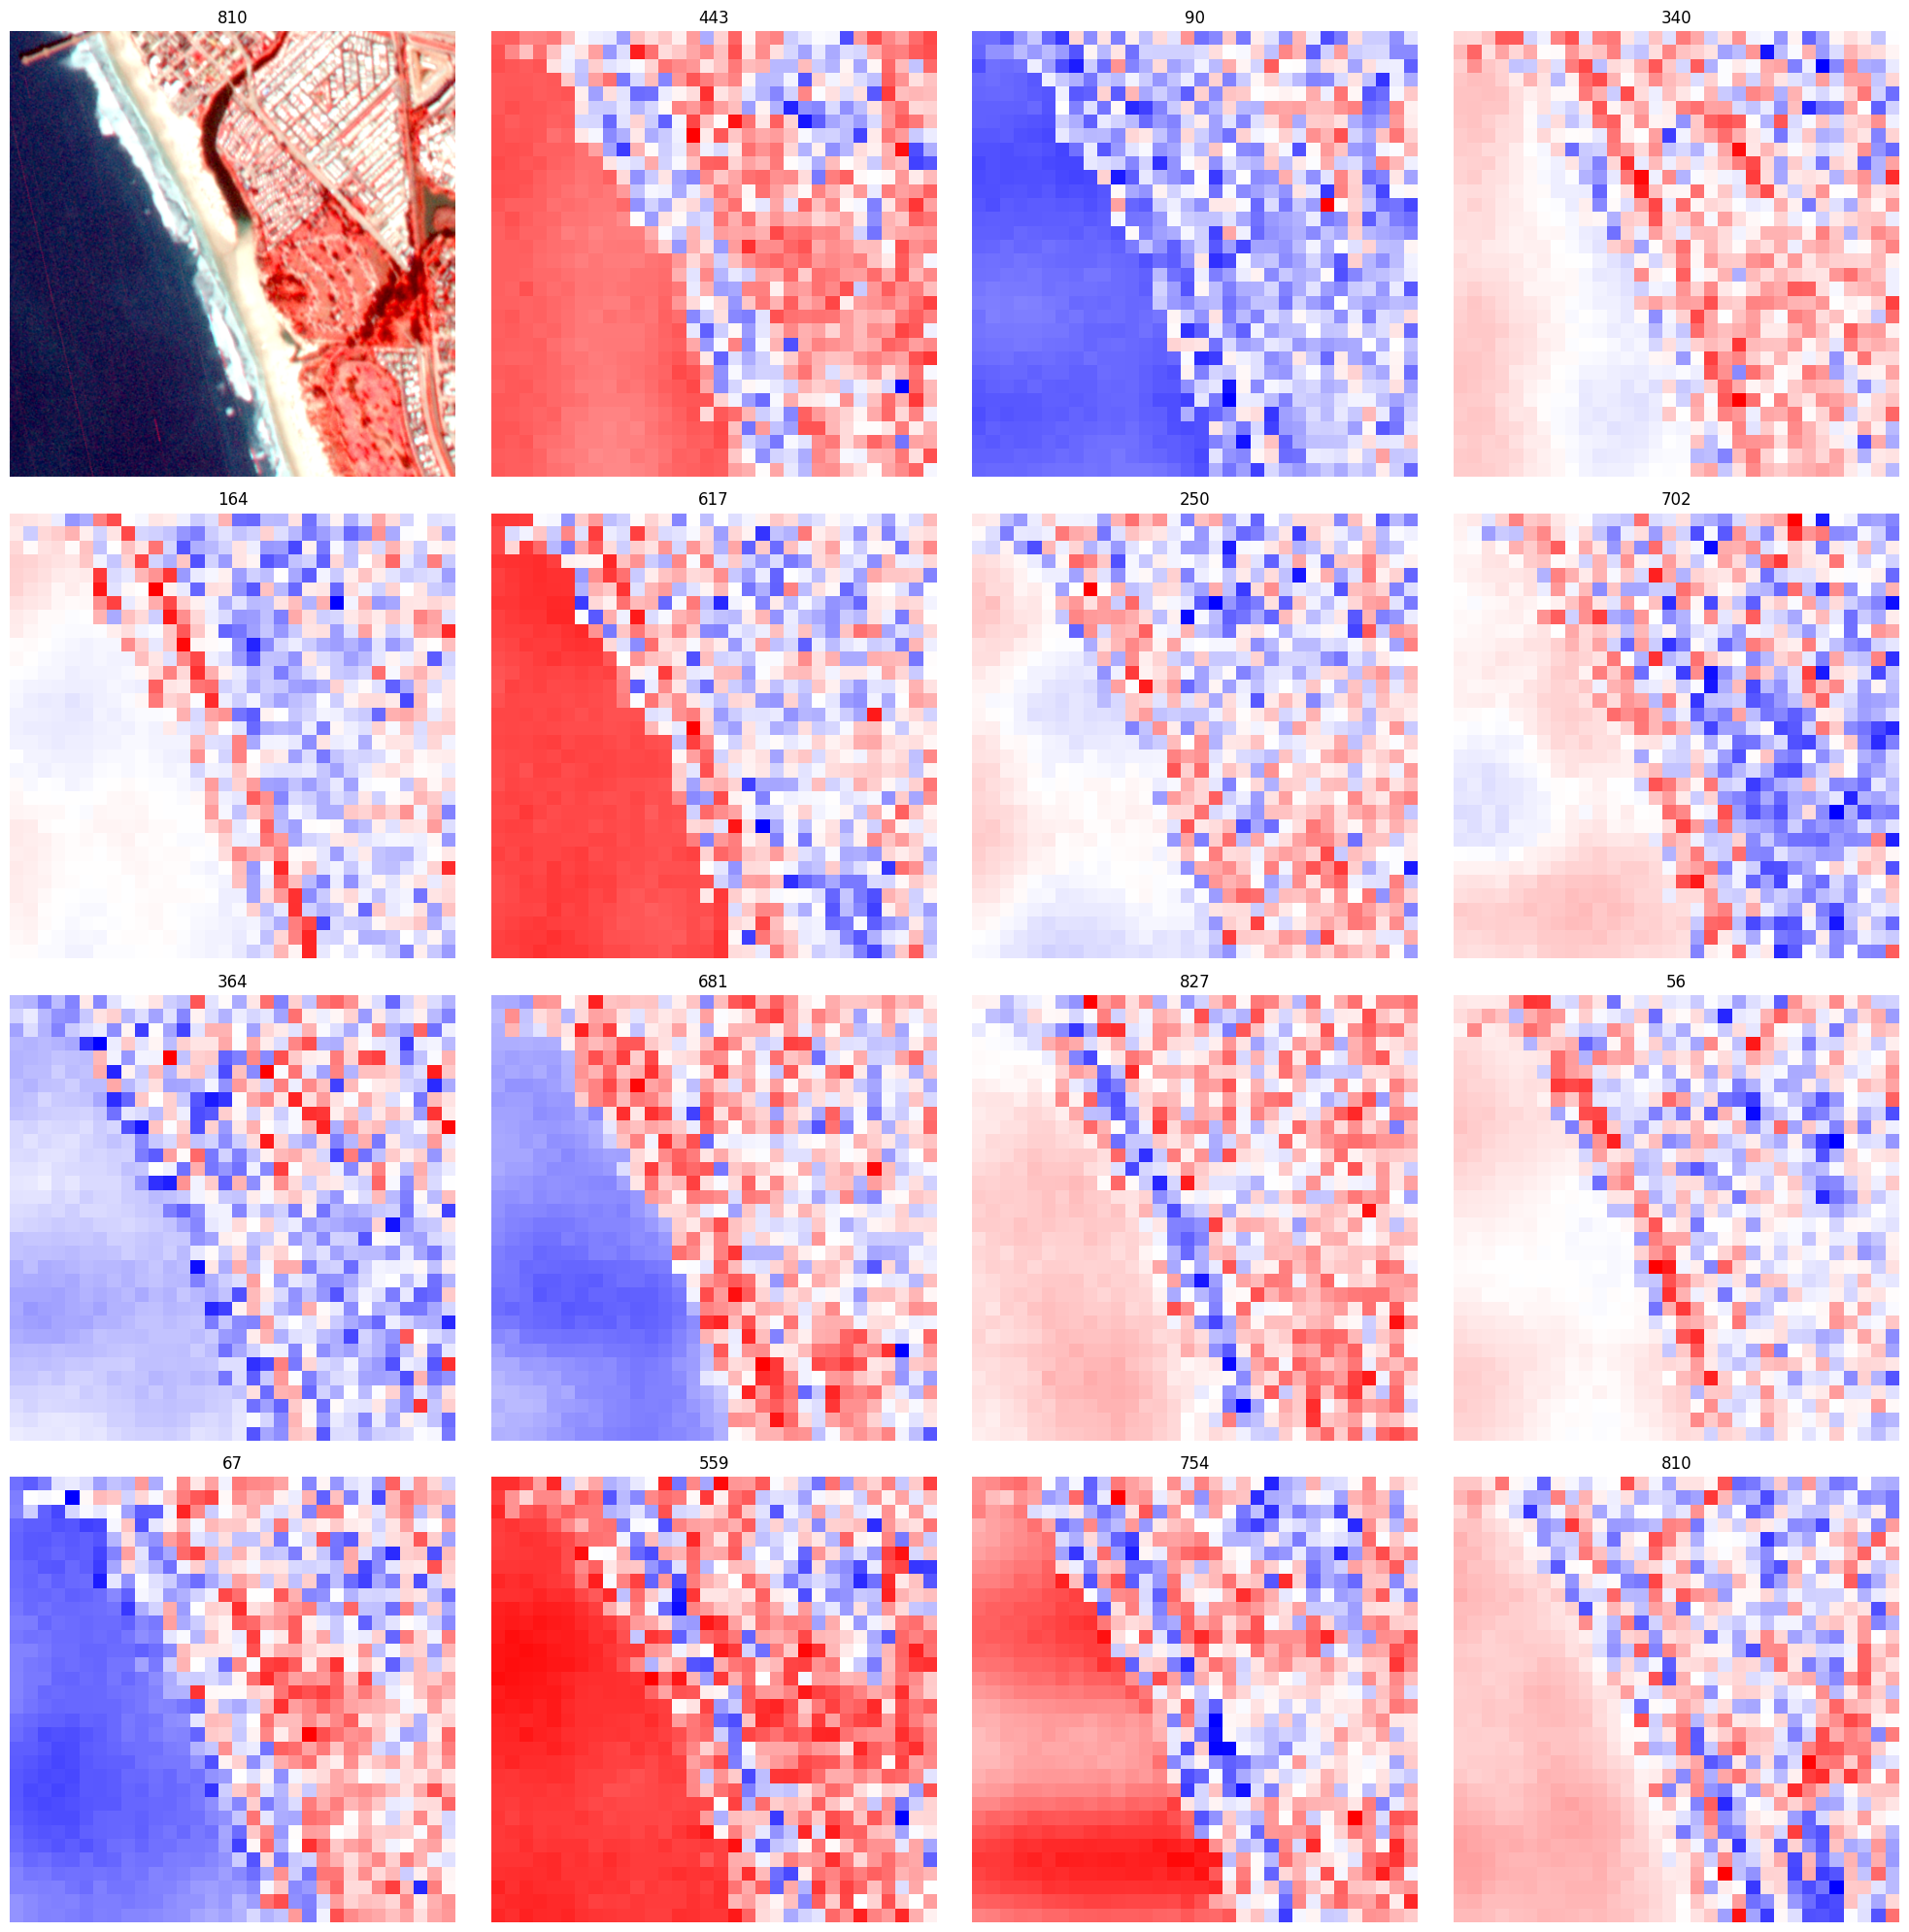

In [115]:
from einops import rearrange

size = 32

embed = rearrange(
    unmsk_patch[:, 1:, :].detach().cpu().numpy(), "b (h w) d-> b d h w", h=size, w=size
)
embed = embed[0]
rows = 4
cols = 4
fig, axs = plt.subplots(cols, cols, figsize=(20, 20))

# idxes = np.random.choice(unmsk_patch.shape[2], rows * cols - 1, replace=False)

for idx, ax in zip(idxes, axs.flatten()[1:], strict=False):
    ax.imshow(embed[idx], cmap="bwr")
    ax.set_axis_off()
    ax.set_title(idx)

ax = axs.flatten()[0]
dd = np.log10(1 + data[[3, 2, 1]].clip(1, 2000))
dd = contrast_stretch(dd)
show(dd, ax=ax)
ax.set_axis_off()
ax.set_title(idx)

plt.tight_layout()

In [116]:
import pandas as pd

labels = pd.read_csv("/Users/kyledorman/data/estuary/label_studio/00023/labels.csv")
labels

,region,source_tif,source_jpeg,label
0,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,transition
1,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,closed
2,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,transition
3,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,closed
4,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,transition
...,...,...,...,...
1495,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
1496,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
1497,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
1498,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open


In [123]:
label_map = {k: i for i, k in enumerate(["closed", "transition", "open", "unsure"])}
labels["label_id"] = labels["label"].map(lambda a: label_map[a])

X = []
for _, row in labels.iterrows():
    pth = Path(row.source_jpeg)
    emb_pth = pth.parent.parent / "embeddings" / f"{pth.stem}.npy"
    emb = np.load(emb_pth)
    X.append(emb)
X = np.array(X)
y = np.array(labels.label_id.tolist())

In [124]:
X.shape, y.shape

((1500, 1024), (1500,))

In [126]:
from sklearn.model_selection import train_test_split

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [139]:
from sklearn.ensemble import RandomForestClassifier

# clf = svm.SVC()
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [144]:
# Predict classes on test set
prediction = clf.predict(X_train)

# Perfect match for SVM
match = np.sum(y_train == prediction)
print(f"Matched {match} out of {len(X_train)} correctly")

Matched 1341 out of 1350 correctly


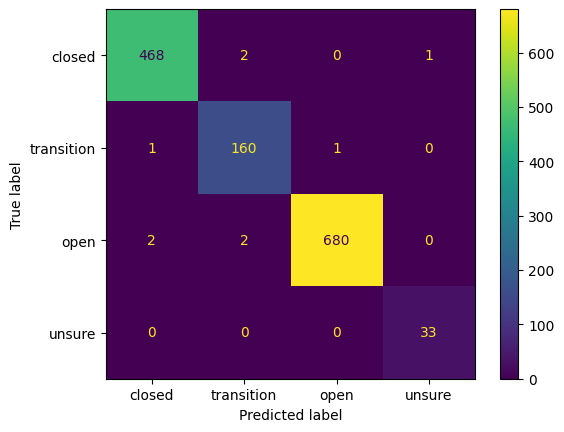

In [145]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_train,
    prediction,
    labels=list(range(len(["closed", "transition", "open", "unsure"]))),
    display_labels=["closed", "transition", "open", "unsure"],
)